In [19]:
!pip install --upgrade --force-reinstall nltk

!pip install tqdm


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl (274 kB)
   ---------------------------------------- 0.0/102.2 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/102.2 kB ? eta -:--:--
   ----------------------- --------------- 61.4/102.2 kB 812.7 kB/s eta 0:00:01
   ----------------------------------- --- 92.2/102.2 kB 751.6 kB/s eta 0:00:01
   -------------------------------------- 102.2/102.2 kB 735.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/307.7 kB ? eta -:--:--
   --------- -------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.4.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.13.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import os
import zipfile
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


from tqdm import tqdm
tqdm.pandas()

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF



In [2]:
def generate_equalized_sample(total, data):

  #Counting Categories  
  key_categories = data['subject_map'].nunique()

  #Counting Sample Per Category We Want
  samples_per_category = int(total / key_categories)

  #Selecting These Samples
  data = (
      data.groupby('subject_map')
      .apply(lambda x: x.sample(n=min(samples_per_category, len(x)), random_state=25))
      .reset_index(drop=True)
  )
  return data

In [3]:
def generate_expanded_data(data):

    #Generating Each Individual Contribution (Paper, Author)
    df_contributions = (
        data
        .assign(
            contributors = data["authors_parsed"].apply(len)
        )
        .explode("authors_parsed", ignore_index=True)
        .rename(columns={"authors_parsed":"contributor"})
        .assign(
            is_lead = lambda d: d.apply(lambda row: any(w.lower() in re.split(r'[^A-Za-z]+', row['contributor'].lower()) for w in re.split(r'[^A-Za-z]+', row['submitter'].lower())), axis=1)
        )
        .loc[:, lambda d: ~d.columns.isin(["authors_parsed","unclean_contributor", "submitter", "authors", "comments", "journal-ref", "doi", "license", "versions", "update_date", "report-no", "categories", "title", "abstract"])]
    )

    #Generating Each Individual Author
    df_authors = (
        df_contributions
        .groupby("contributor")
        .agg(
            papers = ('id', 'count'),
            earliest = ('year', 'min'),
            latest = ('year', 'max'),
            solo = ('contributors', lambda x: (x==1).sum()),
            average_size = ('contributors', 'mean'),
            mapped_category_count = ('mapped_categories', lambda x: x.dropna().nunique()),
            subject_map_count = ('subject_map', lambda x: x.dropna().nunique())
        )
        .reset_index()
        )

    #Merging Data To Make Next Steps Easier
    df_contributions = df_contributions.merge(df_authors[['contributor', 'earliest', 'latest', 'papers']], on='contributor', how='left')
    paper_sums = df_contributions.groupby('id')['papers'].sum().reset_index(name='total_papers')
    data = data.merge(paper_sums, on='id', how='left')
    
    return data, df_contributions, df_authors

In [11]:
#DISTRIBUTION
df = pd.read_json("arxiv_data/arxiv-metadata-oai-snapshot.json", lines=True, nrows=10000)

In [12]:
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

subject_map = {
    "Astrophysics & Cosmology": ["astro-ph", "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE", "astro-ph.IM", "astro-ph.SR"],
    "Condensed Matter Physics": ["cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci", "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft", "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"],
    "Computer Science": ["cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV", "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL", "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO", "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS", "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"],
    "Econometrics & Finance": ["econ.EM", "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR", "q-fin.RM", "q-fin.ST", "q-fin.TR"],
    "Electrical Engineering & Signal Processing": ["eess.AS", "eess.IV", "eess.SP"],
    "General & Theoretical Physics": ["gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math-ph", "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus", "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph", "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn", "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det", "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph", "physics.soc-ph", "physics.space-ph", "quant-ph"],
    "Mathematics": ["math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO", "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM", "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT", "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA", "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG", "math.SP", "math.ST"],
    "Nonlinear Sciences": ["nlin.AO", "nlin.CD", "nlin.CG", "nlin.PS", "nlin.SI"],
    "Nuclear Physics": ["nucl-ex", "nucl-th"],
    "Quantitative Biology": ["q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT", "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"],
    "Statistics & Data Science": ["stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"]
}

# If there are multiple categories associated with the document, take the first one
df['categories'] = df['categories'].str.split().str[0]

# Add subjects instead of the category
category_to_subject = {}
for subject, categories in subject_map.items():
    for category in categories:
        category_to_subject[category] = subject

# Apply the corrected mapping
df['mapped_categories'] = df['categories'].map(category_map)
df['subject_map'] = df['categories'].map(category_to_subject)
df['mapped_categories'] = df['mapped_categories'].fillna('Unknown Category') #should not exist
df['subject_map'] = df['subject_map'].fillna('Unknown Subject')  #should not exist

# Print unique subject mappings (ie. without duplicates)
df[['categories', 'mapped_categories', 'subject_map']].drop_duplicates().head(5)



# Drop rows where 'title' or 'abstract' are missing
df_cleaned = df.dropna(subset=['title', 'abstract'])

# Function to clean text
def clean_text(text):
    # Remove extra spaces and special characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply text cleaning to 'title' and 'abstract' columns
df_cleaned['title'] = df_cleaned['title'].apply(clean_text)
df_cleaned['abstract'] = df_cleaned['abstract'].apply(clean_text)

# Remove duplicate rows based on 'title' and 'abstract'
df_cleaned = df_cleaned.drop_duplicates(subset=['title', 'abstract'])

# Convert the update date to a proper datetime format
df_cleaned['update_date'] = pd.to_datetime(df_cleaned['update_date'], errors='coerce')

# Extract the year from the update date
df_cleaned['year'] = df_cleaned['update_date'].dt.year

# Exclude rows where the category is "Unknown Category"
df_cleaned = df_cleaned[df_cleaned['mapped_categories'] != 'Unknown Category']

"""
Reformats Author Data Into Clean List
"""
def clean_contributors(author_string):

    #Remove Anything In Brackets
    s = re.sub(r'\([^)]*\)', '', author_string)

    #Remove All "and"
    s = re.sub(r'\band\b', '', s, flags=re.IGNORECASE)

    #Remove All "\n"
    s = s.replace('\n', '') 

    #Split And Trim
    return [part.strip() for part in s.split(',') if part.strip()]
    
#Cleans The Author Columns
df_cleaned['authors_parsed'] = df_cleaned['authors'].apply(clean_contributors)
df_cleaned = df_cleaned.drop(columns='authors')

#Store Count
df_cleaned['contributors'] = df['authors_parsed'].apply(len)

#Order 
df_cleaned = df_cleaned.sort_values(by='id')

#Importing Code

In [13]:
#DISTRIBUTION
df_cleaned = df_cleaned.head(10000) #generate_expanded_data(10000 df_cleaned) 

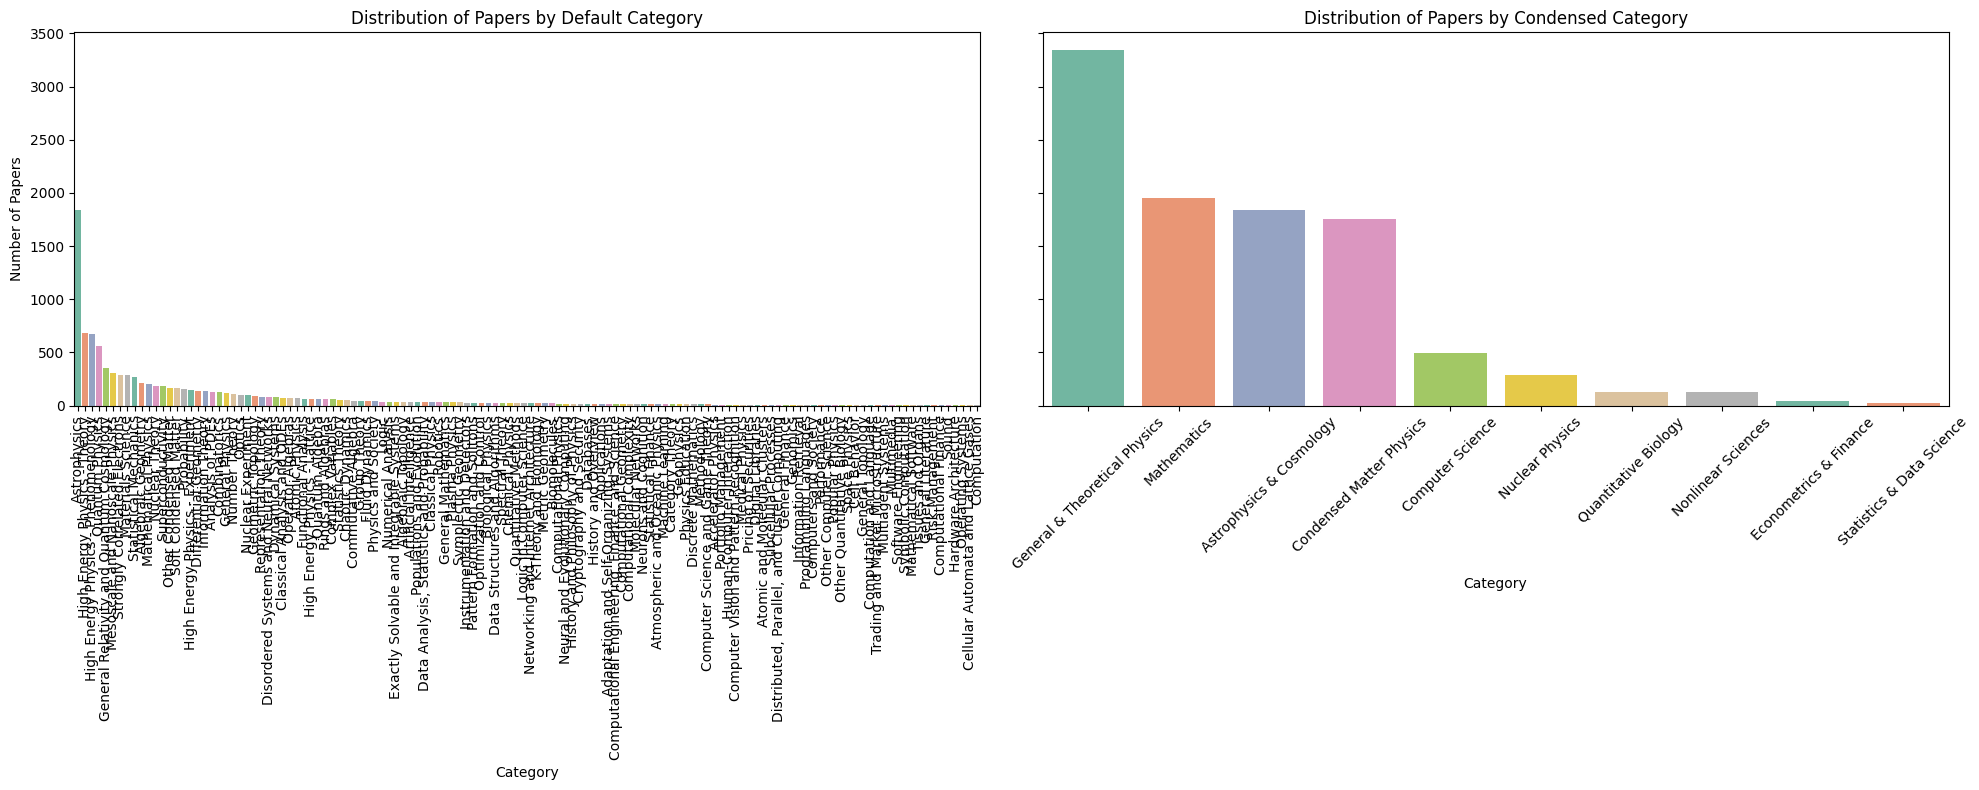

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Count categories
counts_orig = df_cleaned['mapped_categories'].value_counts().reset_index()
counts_orig.columns = ['Category', 'Count']

counts_cond = df_cleaned['subject_map'].value_counts().reset_index()
counts_cond.columns = ['Category', 'Count']

# Plot original categories with hue workaround
sns.barplot(data=counts_orig,x='Category',y='Count',hue='Category',palette='Set2',legend=False,ax=axes[0])
axes[0].set_title('Distribution of Papers by Default Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Papers')
axes[0].tick_params(axis='x', rotation=90)

# Plot condensed categories with hue workaround
sns.barplot(data=counts_cond,x='Category',y='Count', hue='Category',palette='Set2',legend=False,ax=axes[1])
axes[1].set_title('Distribution of Papers by Condensed Category')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
model_full_bert = 'bert-base-uncased'
model_sentence = 'all-MiniLM-L6-v2'

#Tokenizers And Models Required
full_tokenizer = BertTokenizer.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
full_model = BertModel.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
full_model.eval()


#Generate Embeddings
def token_embedding(text):
        inputs = full_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad(): outputs = full_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.numpy().flatten()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_cleaned['title_embeddings'] = df_cleaned['title'].progress_apply(token_embedding)

In [24]:
df_cleaned['abstract_embeddings'] = df_cleaned['abstract'].progress_apply(token_embedding)

100%|██████████| 10000/10000 [44:07<00:00,  3.78it/s] 


In [25]:
df_cleaned['joined_embeddings'] = (df_cleaned['abstract_embeddings']+df_cleaned['title_embeddings'])/2

In [28]:
df_temp = df_cleaned.copy()

In [80]:
#df_temp.to_pickle("stored_df.pkl")

df_cleaned = pd.read_pickle("stored_df.pkl")

In [82]:
df_cleaned, df_contributions, df_authors = generate_expanded_data(df_cleaned)

In [153]:
df_authors.sample(5)

,contributor,papers,earliest,latest,solo,average_size,mapped_category_count,subject_map_count
3119,Boris A. Malomed,2,2007,2009,0,3.0,2,2
17872,P.Baldi,1,2021,2021,0,3.0,1,1
10081,J. Houck,2,2009,2009,0,13.0,1,1
14750,M. Sami I. Thongkool,1,2008,2008,0,5.0,1,1
10650,J. Quintanilla,1,2008,2008,0,4.0,1,1


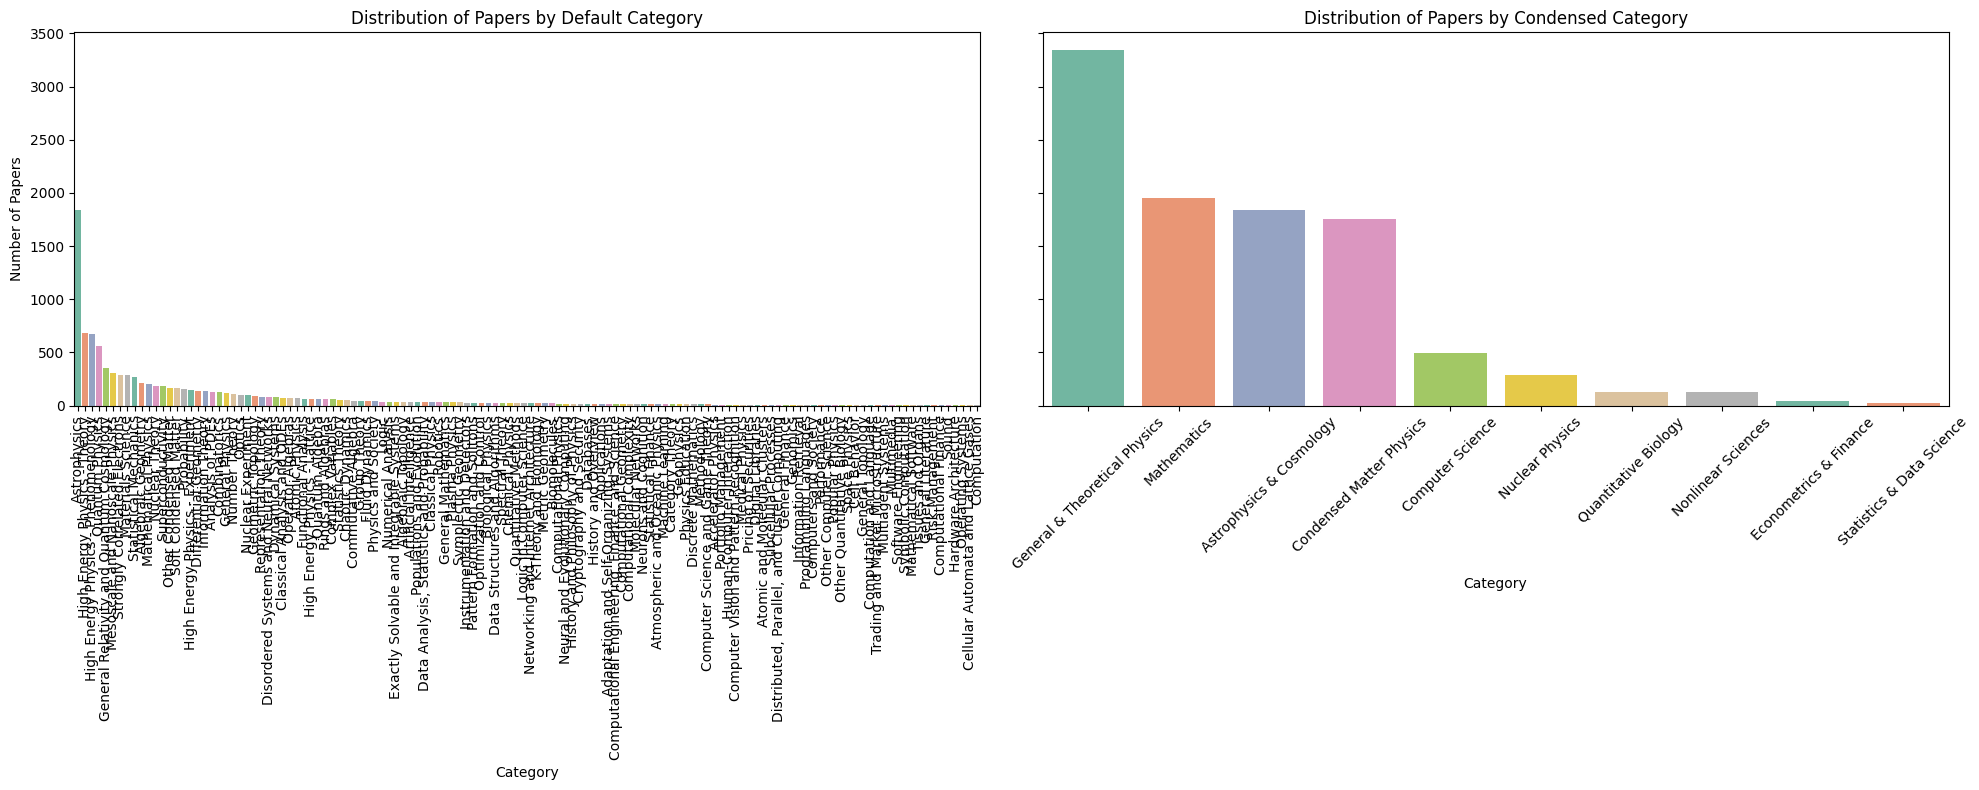

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Count categories
counts_orig = df_cleaned['mapped_categories'].value_counts().reset_index()
counts_orig.columns = ['Category', 'Count']

counts_cond = df_cleaned['subject_map'].value_counts().reset_index()
counts_cond.columns = ['Category', 'Count']

# Plot original categories with hue workaround
sns.barplot(data=counts_orig,x='Category',y='Count',hue='Category',palette='Set2',legend=False,ax=axes[0])
axes[0].set_title('Distribution of Papers by Default Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Papers')
axes[0].tick_params(axis='x', rotation=90)

# Plot condensed categories with hue workaround
sns.barplot(data=counts_cond,x='Category',y='Count', hue='Category',palette='Set2',legend=False,ax=axes[1])
axes[1].set_title('Distribution of Papers by Condensed Category')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

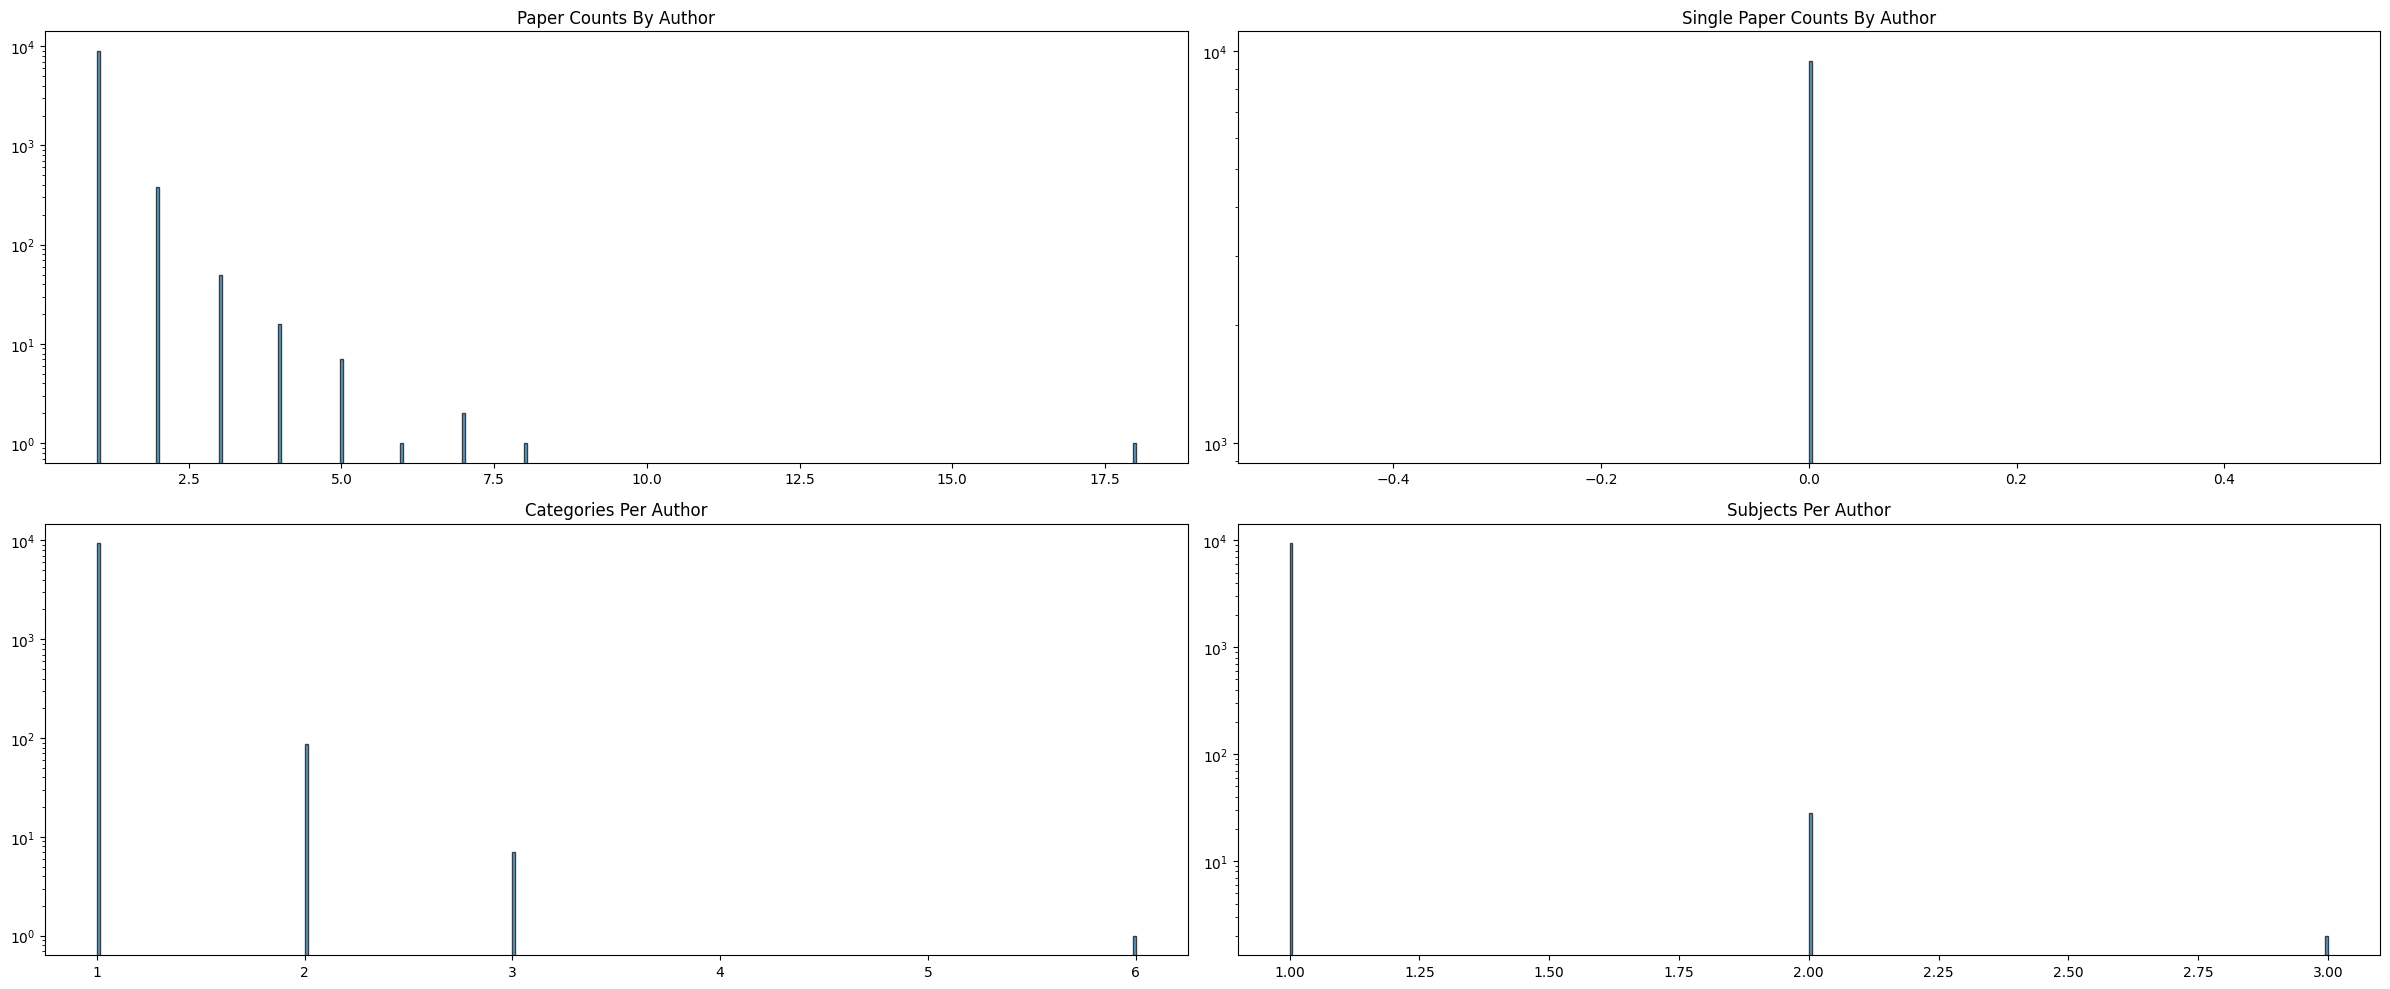

In [34]:
def plot_distribution(ax, data, title):
    ax.hist(data, bins=350, edgecolor="black", alpha=0.7)
    ax.set_yscale('log')
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(24, 10)) 

plot_distribution(axes[0,0], df_authors["papers"], "Paper Counts By Author")
plot_distribution(axes[0,1], df_authors["solo"], "Single Paper Counts By Author")
plot_distribution(axes[1,0], df_authors["mapped_category_count"], "Categories Per Author")
plot_distribution(axes[1,1], df_authors["subject_map_count"], "Subjects Per Author")
plt.tight_layout()
plt.show()

In [154]:
#Generates The Average Author Embedding Using Weighted Papers They Contributed To
def paper_contribution_to_author(group,chosen_embedding):
    
    duration = np.maximum(group['latest']-group['earliest'],1)
    point_within = group['year']-group['earliest']

    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  np.log(point_within/duration + 3)          # Use Point In Career

                  * ( 1 + group['is_lead']*5 )                  # Role In Paper

                  * np.sqrt(1 / group['contributors'])  # Inverse Contributors 
    )


# Generates The Average Paper Embedding Usings Weighted Authors That Contributed To It
def authors_contribution_to_paper(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  (1 + group['is_lead']*5 )       #More If Author Leading It

                  * np.sqrt(group['papers'])                #More If Many Papers Mad
                  
                  * (1 - 0.2 *(group['papers'] == 1))         #Less If This Is Only Paper Made By Author (Dilutes)

                  *  1/group['average_size']   #  More If Authors Have Lower Average Paper Size

                  * (1 + 2*group['solo'])    #More If Authors Have Completed Solo Papers
    )

In [91]:
#Generates The Average Embeddings For A Category Using The Weighted Papers Within It
def paper_contribution_to_category(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis = 0 ,
        weights = np.sqrt(group['contributors'].values) 
                  * np.sqrt(group['total_papers']/group['contributors'])
    )

In [92]:
#A Method That Generates An Alternative Embedding For A Paper, By Generating An Embedding For Each Author, 
#Then Aggregating Each Papers Contributors Embeddings 
def generate_alternative_embeddings(chosen_embeddings, contributions):

    author_embeddings = (
        contributions
        .groupby('contributor')
        .apply(lambda group: paper_contribution_to_author(group,chosen_embeddings), include_groups=False)
        .reset_index(name = "author_" + chosen_embeddings)
    )

    contributions = contributions.merge(author_embeddings, on='contributor', how='left')

    #Generate New Paper Embedding
    alternative_embeddings = (
        contributions
        .groupby('id')
        .apply(lambda group: authors_contribution_to_paper(group, "author_" + chosen_embeddings), include_groups=False)
        .reset_index(name= "alternative_" + chosen_embeddings)
        .sort_values('id')
    )

    #Returning New Embedding
    return list(alternative_embeddings["alternative_" + chosen_embeddings])

In [155]:
df_cleaned["alternative_joined"] = generate_alternative_embeddings("joined_embeddings",df_contributions)

KeyError: 'average_size'

In [42]:
custom_order = ['General & Theoretical Physics', 'Mathematics', 'Condensed Matter Physics', 'Astrophysics & Cosmology', 'Nonlinear Sciences', 'Quantitative Biology', 'Computer Science', 'Nuclear Physics',
                 'Econometrics & Finance', 'Statistics & Data Science']

df_cleaned['subject_map'] = pd.Categorical(df_cleaned['subject_map'], categories=custom_order, ordered=True)
df_cleaned = df_cleaned.sort_values('subject_map')

In [77]:
def compute_combined_category_similarity_matrix(title_column, abstract_column, df):

    # Combine title and abstract embeddings by averaging them
    combined_embeddings = np.array([0.5 * (title + abstract) for title, abstract in zip(df[title_column], df[abstract_column])])

    # Compute cosine similarity between all combined embeddings
    similarity_matrix = cosine_similarity(combined_embeddings)

    # Get the unique categories
    categories = df['subject_map'].unique()

    # Initialize a matrix to store average similarity scores between categories
    category_sim_matrix = np.zeros((len(categories), len(categories)))

    # Loop over all pairs of categories
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):

            # Get the indices for both categories
            indices1 = df[df['subject_map'] == cat1].index
            indices2 = df[df['subject_map'] == cat2].index

            # Get the cosine similarity between all pairs of documents in category cat1 and cat2
            similarity_values = similarity_matrix[np.ix_(indices1, indices2)]

            # Calculate the mean similarity for this category pair
            category_sim_matrix[i, j] = np.mean(similarity_values)

    # Convert the similarity matrix to a DataFrame with category labels
    category_sim_df = pd.DataFrame(category_sim_matrix, index=categories, columns=categories)

    return category_sim_df

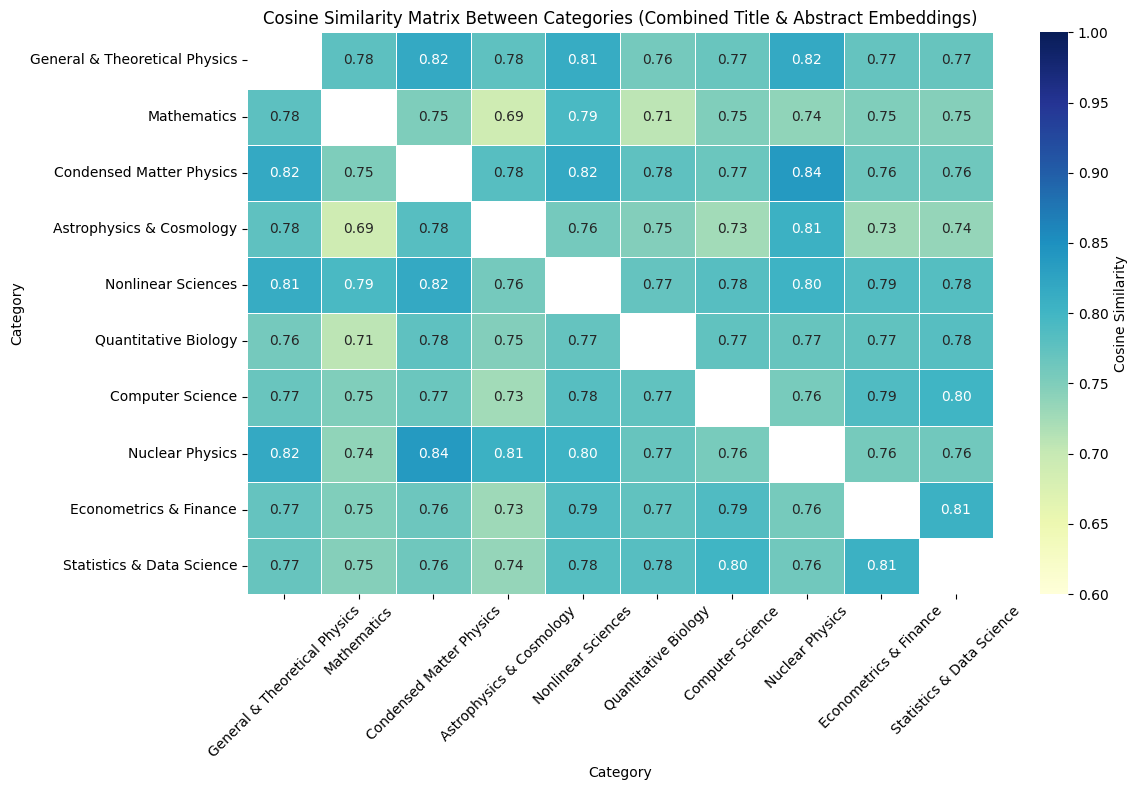

In [86]:
# Compute the similarity matrix using combined title and abstract embeddings
category_similarity_df = compute_combined_category_similarity_matrix('joined_embeddings', 'joined_embeddings', df_cleaned)

# Set diagonal to NaN to avoid self-similarity being shown
np.fill_diagonal(category_similarity_df.values, np.nan)

# Plot the heatmap for the category similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    category_similarity_df,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    vmin=0.6,  # Set the minimum value for color scale
    vmax=1,  # Set the maximum value for color scale
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Cosine Similarity Matrix Between Categories (Combined Title & Abstract Embeddings)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

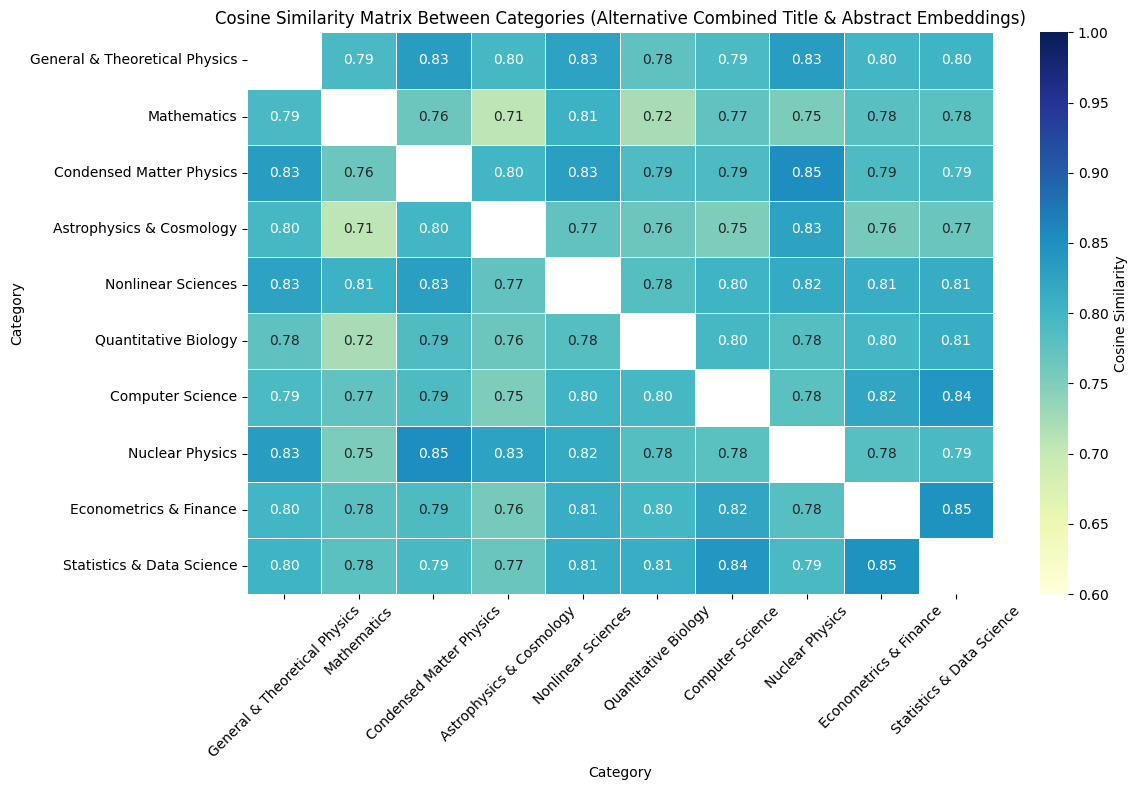

In [ ]:
# Compute the similarity matrix using combined title and abstract embeddings
category_similarity_df = compute_combined_category_similarity_matrix('alternative_joined', 'alternative_joined', df_cleaned)

# Set diagonal to NaN to avoid self-similarity being shown
np.fill_diagonal(category_similarity_df.values, np.nan)

# Plot the heatmap for the category similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    category_similarity_df,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    vmin=0.6,  # Set the minimum value for color scale
    vmax=1,  # Set the maximum value for color scale
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Cosine Similarity Matrix Between Categories (Alternative Combined Title & Abstract Embeddings)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
AlternativeSimilarityHeatmap

In [ ]:

\begin{figure}
    \centering
    \includegraphics[width=0.1\linewidth]{AltHeatmap.png}
    \caption{Enter Caption}
    \label{fig:enter-label}
\end{figure}